In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from importlib import reload
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns
from sklearn.cluster import KMeans

from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens
from src.scoring_functions import cosine_sim, entropy, content_fairness
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, TopicInteractionMeasurement, MeanNumberOfTopics

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

## Creating RecommenderSystem on MovieLens 

In [ ]:
n_attrs=20
max_iter=1000
n_clusters=25

In [ ]:
binary_ratings_matrix = load_and_process_movielens(file_path='data/ml-100k/u.data')

In [ ]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [ ]:
def get_clusters(embeddings, name, n_clusters:int=25, n_attrs:int=20, max_iter:int=100):
    """
    Creates clusters of movies based on their genre.
    Inputs:
        embeddings: Matrix of embeddings, e.g. user representation
        n_attrs: number of attributes to use in NMF
        nmf_solver: solver to use in NMF
    Outputs:
        clusters: a list of cluster assignments
    """
    # Create topic clusters
    #create co-occurence matrix from binary_interaction_matrix
    file_path = f'artefacts/topic_clusters/{name}_clusters_{n_clusters}clusters_{n_attrs}attributes_{max_iter}iters.pkl'
    if not os.path.exists(file_path):
        print('Calculating clusters...')

        kmeans = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state).fit(embeddings)
        pickle.dump(kmeans, open(file_path, 'wb'))

        print('Calculated clusters.')
    else:         
        # load the model from disk
        kmeans = pickle.load(open(file_path, 'rb'))
        print('Loaded clusters.')

    cluster_ids = kmeans.predict(embeddings)
    centroids = kmeans.cluster_centers_
    return cluster_ids, centroids


In [ ]:
# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded clusters.
Loaded clusters.


In [ ]:
print(item_cluster_centers.shape)
print(user_cluster_centers.shape)

(25, 20)
(25, 20)


In [ ]:
euclidean_distance_matrix = np.empty((n_clusters, n_clusters), dtype=float)
for i, user_cluster in enumerate(user_cluster_centers):
    for j, item_cluster in enumerate(item_cluster_centers):
        euclidean_distance_matrix[i, j] = np.linalg.norm(user_cluster - item_cluster)

# display(pd.DataFrame(euclidean_distance_matrix))
user_cluster_item_cluster_assignments = np.argmin(euclidean_distance_matrix, axis=1)
print(user_cluster_item_cluster_assignments)

[14 21 14 21 14  1 14 14  1  1  1 21  1 14  6  1  1 14 14 23  1  1  1 14
  1]


## Cluster experiments

In [60]:
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import colorcet as cc
from scipy import interpolate
from scipy.spatial import ConvexHull

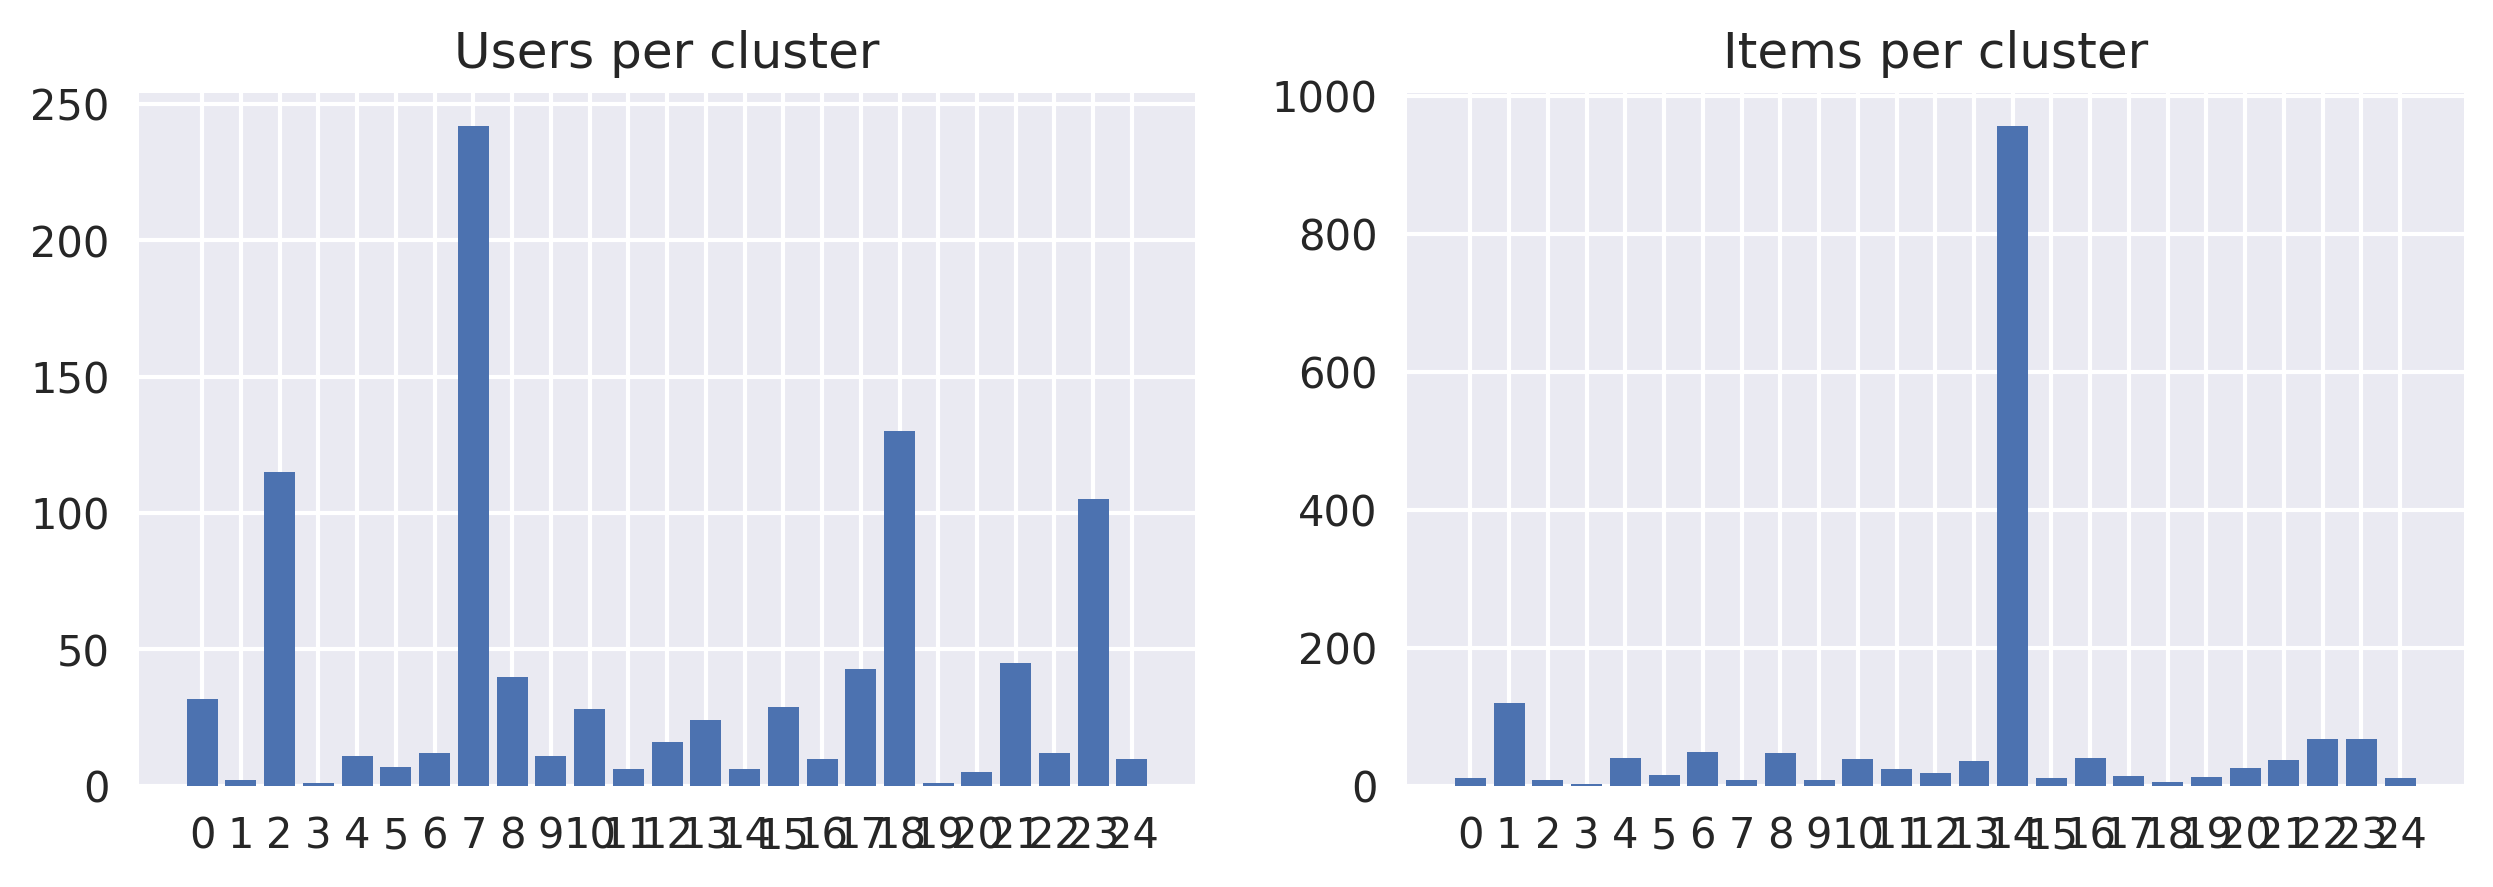

In [58]:
# count number of occurences in cluster_ids
fig, axs = plt.subplots(1,2, figsize=(10, 3))

cluster_counts = np.bincount(user_cluster_ids)

# plot bar chart where x axis is cluster_id and height is number of items in a cluster
axs[0].bar(x=range(len(cluster_counts)), height=cluster_counts)
axs[0].set_xticks(range(len(cluster_counts)), range(0, len(cluster_counts)))
axs[0].set_title('Users per cluster')

# count number of occurences in cluster_ids
cluster_counts = np.bincount(item_cluster_ids)
axs[1].bar(x=range(len(cluster_counts)), height=cluster_counts)
axs[1].set_xticks(range(len(cluster_counts)), range(0, len(cluster_counts)))
axs[1].set_title('Items per cluster')
plt.show()

### Visualize clusters prior to Simulation

In [33]:
# Using user representation and clusters from NMF to visualize user separation
x = user_representation
y = user_cluster_ids

perplexity = 50
tsne = TSNE(perplexity=perplexity, n_components=2, verbose=0, random_state=42)
z = tsne.fit_transform(x)

In [34]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

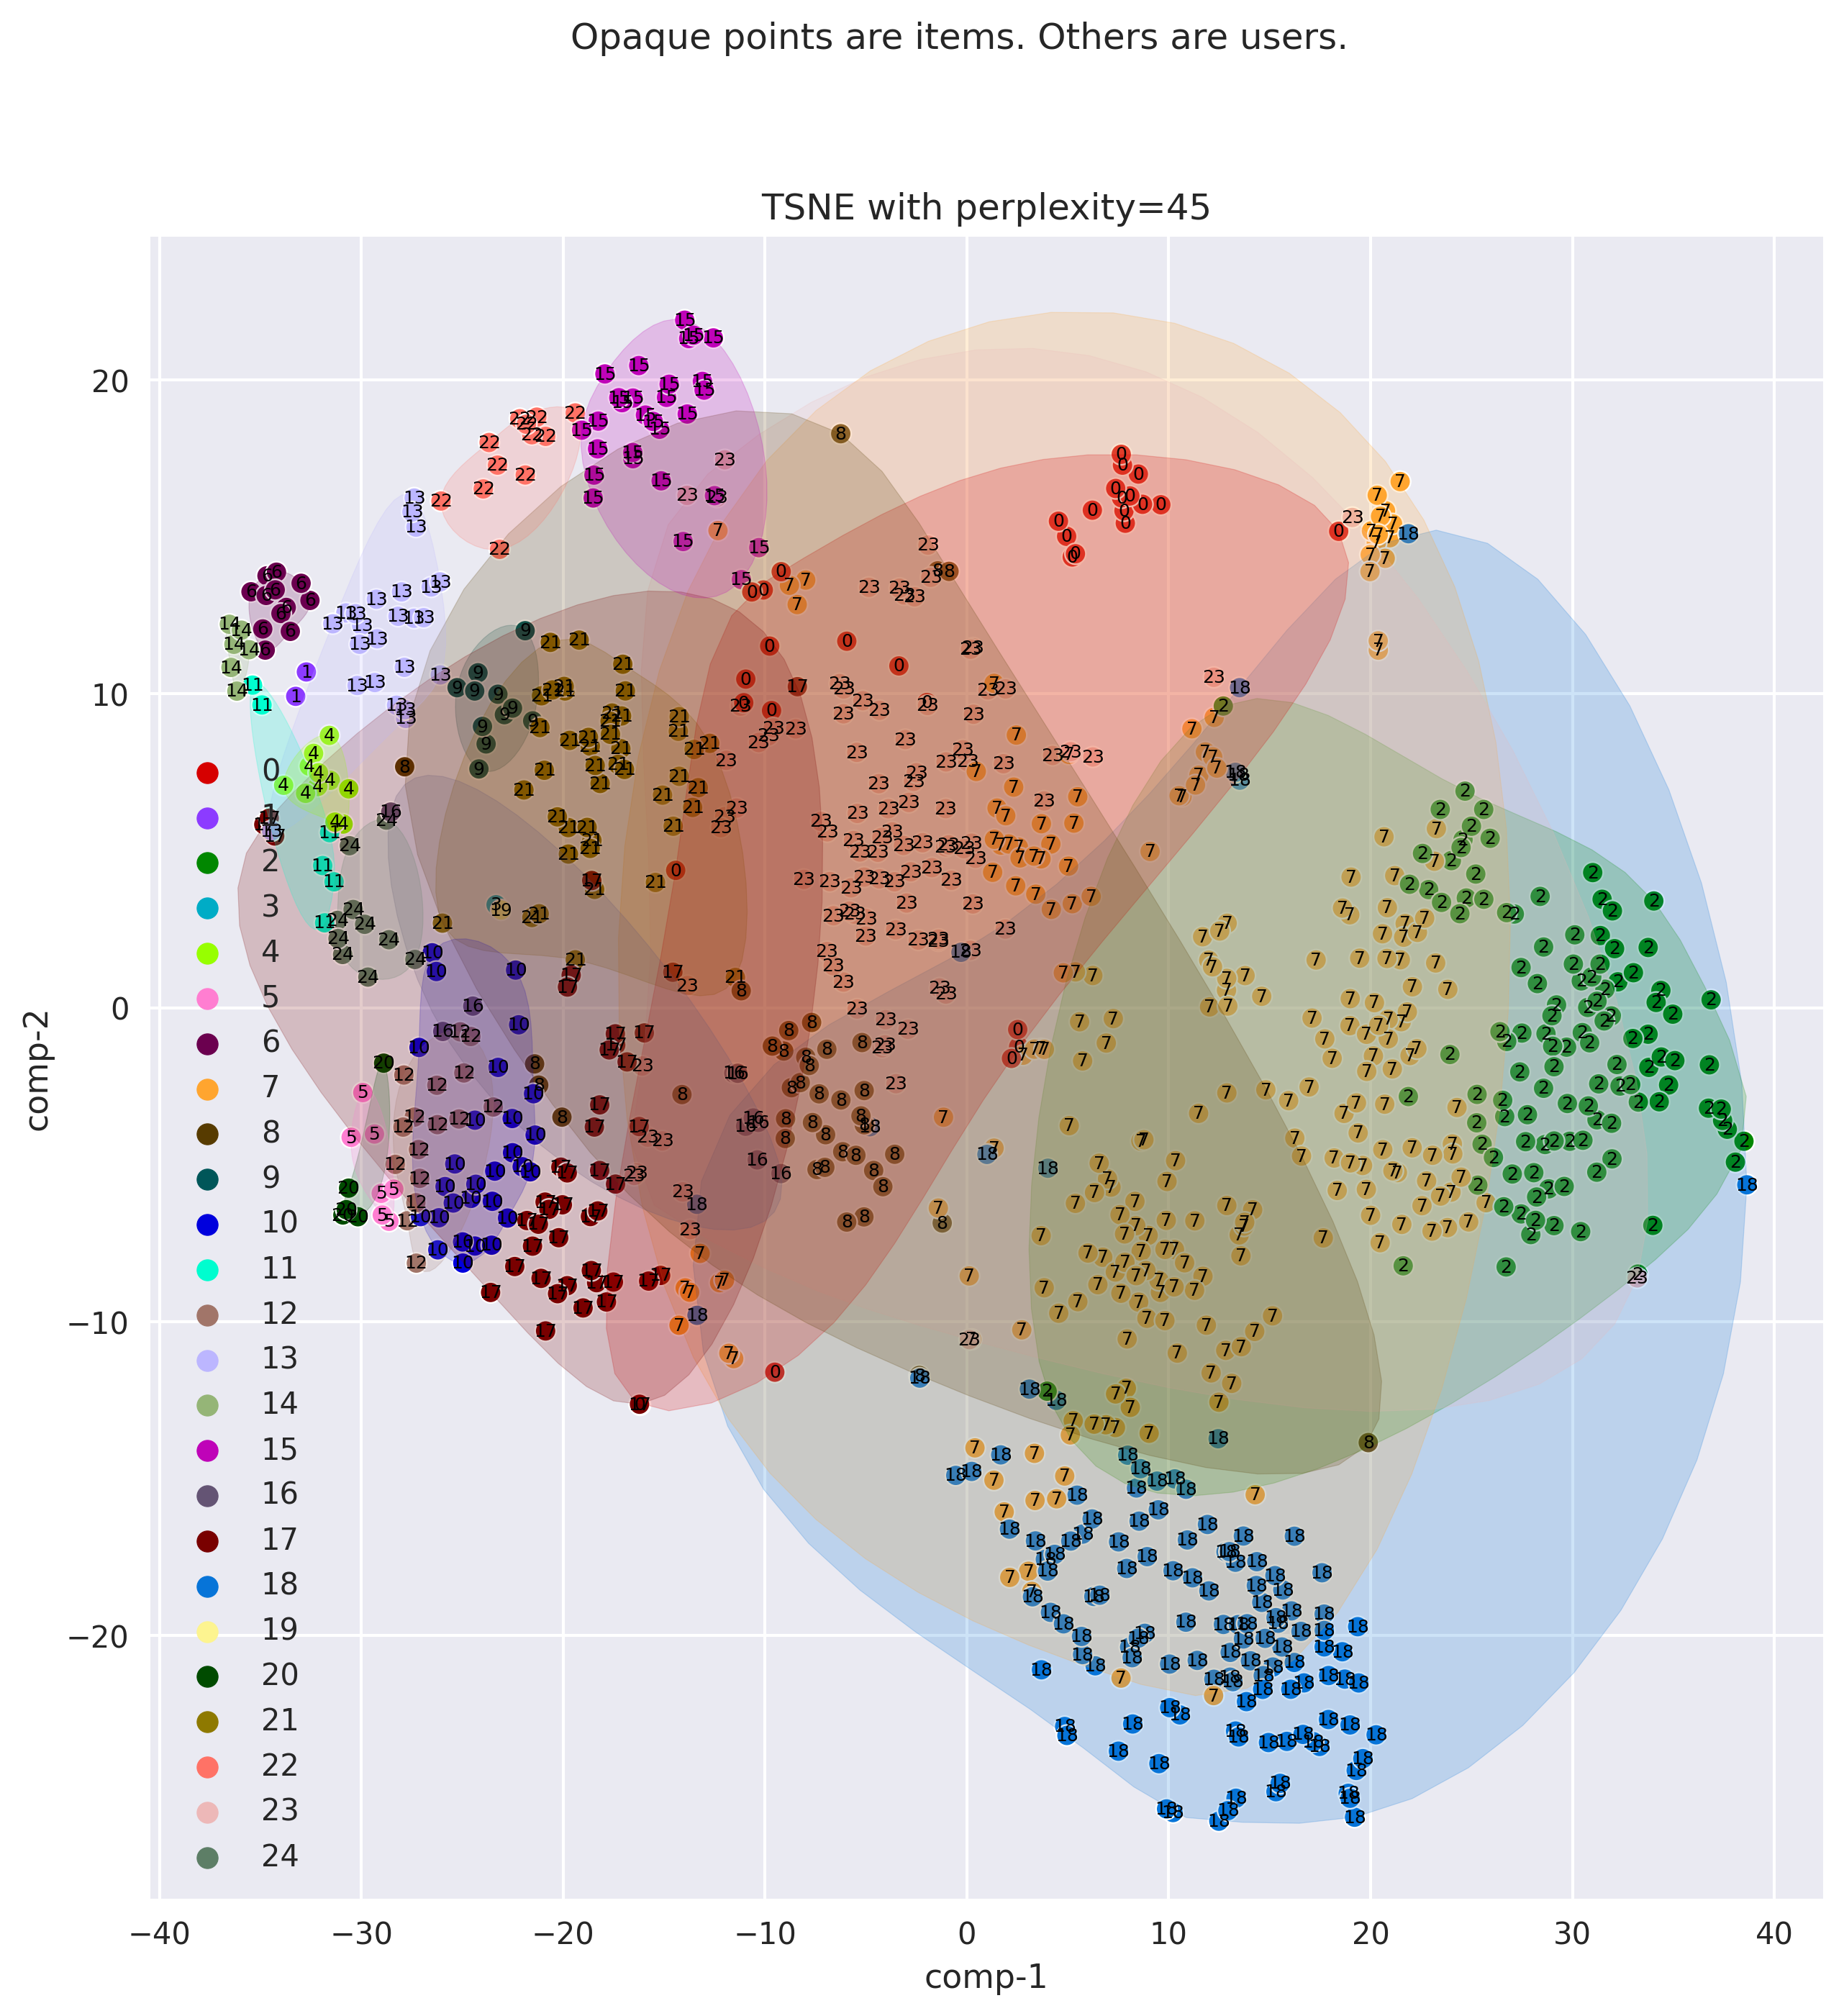

In [61]:
# plot tsne
plt.rcParams['figure.dpi'] = 300
fig = plt.figure(figsize=(10, 10))

palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(y)))

# sns.scatterplot(x="comp-1", y="comp-2", hue=df[df['rep_type'] == 'item'].y.tolist(),
#                 palette=sns.color_palette("hls", n_attrs), alpha=0.2,
#                 data=df[df['rep_type'] == 'item']).set(title="")
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=palette, alpha=1,
                data=df).set(title="")

# Label points
for ind in df.index:
    plt.text(x=df['comp-1'][ind], y=df['comp-2'][ind], s=df['y'][ind], color='black', fontsize=6, horizontalalignment='center', verticalalignment='center')

    
# Create hulls
for i in df.y.unique():
    points = df[df.y == i][['comp-1', 'comp-2']].values
    if len(points) >= 3:
        # get convex hull
        hull = ConvexHull(points)
        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(points[hull.vertices,0],
                           points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                           points[hull.vertices,1][0])
        # interpolate
        dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
        dist_along = np.concatenate(([0], dist.cumsum()))
        spline, u = interpolate.splprep([x_hull, y_hull], 
                                        u=dist_along, s=0, per=1)
        interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
        interp_x, interp_y = interpolate.splev(interp_d, spline)
        # plot shape
        plt.fill(interp_x, interp_y, '--', c=palette[i], alpha=0.2)    
    
    
plt.title(f'TSNE with perplexity={perplexity}')
plt.suptitle(f'Opaque points are items. Others are users.')
plt.show()

### Visualize clusters post simulation

In [ ]:
path = 'artefacts/final_preferences/' + 'myopic_final_preferences_1trainTimesteps_1runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_FalsePairAll.npy'

user_pref = np.load(path, allow_pickle=True)